Trends and Classification of Popular Music from 1960-2020
===
Alex Holtz, Anthony Naritsin, Rose Riggs
### Outline
0. Introduction
1. Gathering Data
    1. Billboard Hot 100 Web Scraping
    2. Spotify Track ID Collection
    3. ID Selection
    4. Get Audio Features
    5. Get Genre
2. Exploratory Data Analysis
    1. Exploration of Features
    2. Exploration of Genres
3. Hypothesis Testing & Machine Learning
4. Conclusion

Introduction
===
Despite the fluid nature of popular music, it has always remained an important aspect of people’s lives. Alongside its significance, there are a few questions about music that have remained prevalent. For one, people always want to know what the next hit song will be. Second, how can we define eras of music using our knowledge of the top music of the past? Finally, we tend to classify music in broad terms, but what underlying characteristics define these categories?

We can attempt to answer all of these questions through the data science pipeline. By analyzing the features of past popular songs, we can investigate what made them popular and how this may have changed over time. Knowing how people categorize these songs, we can see what features might lead us to these categories.

Part 1: Gathering Data
===
There are many resources that provide datasets that have already been collected and formatted: [Kaggle](https://www.kaggle.com/datasets), [Google Public Data Explorer](https://www.google.com/publicdata/directory), and [The U.S. Government Database](https://www.data.gov/), just to name a few. However, we wanted to explore popular songs with their features over a long period of time, and we settled upon the Billboard Hot 100 Songs Year End Charts, which were not well represented in pre-existing datasets. We chose this data because it would allow us to investigate our two main ideas: how popular music changes over time and can we classify popular music.

Data can be difficult to find in a format that is standard and that provides everything you are looking for. In our case, the Billboard Charts provide the rank, title, and artists, but lack other characteristics of the music. To accommodate for this we utilized the Spotify API to wrangle a variety of other features as well as genre.

Throughout this tutorial we will be using [Pandas](https://pandas.pydata.org/docs/reference/), [Numpy](https://numpy.org/doc/), and [Matplotlib](https://matplotlib.org) to store, manipulate, and visualize our data.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Part 1.1: Billboard Top 100 Web Scraping
===
To get information on popular songs for each year, we decided to use the Billboard Hot 100 Songs Year End Charts. Initially we looked at the [Billboard website](https://www.billboard.com/charts/year-end/hot-100-songs), but the website only goes back to charts from 2005, and our goal was to span a much larger time frame than just 15 years. We eventually decided on using the data from Wikipedia, which includes lists of the Billboard Hot 100 songs for most years back to 1946. After 1960, there were no missing years, so we decided to work with the time frame of 1960-2020. 

In order to get the songs from Wikipedia, we scrape the information from the webpage. For this we are using Requests and BeautifulSoup. [Requests](https://pypi.org/project/requests/) is a python library for making HTTP requests, which we use to get the HTML content of the webpages. [BeautifulSoup](https://pypi.org/project/beautifulsoup4/) is a library which allows us to search within the HTML and parse it to get the data we are looking for.


In [2]:
# Imports for web scraping
import requests
from bs4 import BeautifulSoup

We are using pandas to store and manipulate our data, as it allows us to store relational data within memory, and provides helpful functions for reading in and exporting data. Each year is a separate page on Wikipedia, but we found that the format of the URL follows the pattern "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of\_*[year]*". Iterating over every year in the period we chose, we use the requests library to get the HTML content of the page, then use Beautiful Soup to parse the string into an object. Using our browser developer tools to select the table element with the songs, we see that the table uses the class "wikitable". With this information, we can select the proper table and read it into a pandas DataFrame.

In [3]:
top100 = pd.DataFrame()

# General form of URL
url = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_'
for year in range(1960, 2021):
    # Get HTML from URL and parse
    r = requests.get(url + str(year))
    html = r.content
    root = BeautifulSoup(r.content, "html.parser")

    # Search for a table with the class "wiki table" and read into dataframe
    r = root.find("table", "wikitable")
    pretty = r.prettify()
    df = pd.read_html(pretty)[0]

    # Rename columns and add a column for the year
    df.columns = ['Rank', 'Song', 'Artist(s)']
    df = df.assign(Year = year)

    # Add dataframe to top100
    top100 = top100.append(df)

display(top100.head())
top100.info()

,Rank,Song,Artist(s),Year
0,1,""" Theme from A Summer Place """,Percy Faith,1960
1,2,""" He'll Have to Go """,Jim Reeves,1960
2,3,""" Cathy's Clown """,The Everly Brothers,1960
3,4,""" Running Bear """,Johnny Preston,1960
4,5,""" Teen Angel """,Mark Dinning,1960


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6101 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rank       6101 non-null   object
 1   Song       6101 non-null   object
 2   Artist(s)  6101 non-null   object
 3   Year       6101 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.3+ KB


After gathering all of the songs into one DataFrame, we display some information about the DataFrame so we can check that we have all of the data we expect. If we had 100 songs for each of the 61 years we looked at, we would have 6100 rows in the DataFrame. Instead, we have 6101. Additionally, the "Rank" column has the data type `object`, even though every element should be an integer. Exploring our data further, we found that both problems have the same source. One rank is listed as 'Tie', which causes there to be more than 100 rows for the year 1969, as well as prevents the column from having type `int64`. Going to our orginal data source, we can confirm that this is a tie for the rank of 100 in 1969. In order to resolve the type problem, we reassign the rank for this row to 100, then cast the column to have type `int64`. 

Additionally, when we display the first 5 rows of our data, we can see that the song titles are surrounded by quotation marks, which could cause problems for our search later on, so we will remove them now.

In [4]:
# Reformat rank to be integers
top100.loc[top100['Rank'] == 'Tie', 'Rank'] = 100
top100 = top100.astype({'Rank': 'int64'})

# Remove quotations from song titles
top100["Song"] = top100["Song"].str.strip('"').str.strip()
top100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6101 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rank       6101 non-null   int64 
 1   Song       6101 non-null   object
 2   Artist(s)  6101 non-null   object
 3   Year       6101 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.3+ KB


Periodically, we will be saving our current DataFrame to a .csv file. We decided to do this because the nature of our data collection, making many HTTP requests, has a high risk of uncontrollable errors, including server time-out, API rate-limiting, etc. This type of data collection can also be fairly slow. Saving the data to an external file allows us to access the data at a later time without rerunning the code, and also helps mitigate the risk of losing all of the previously collected information due to an unexpected error.

In [ ]:
# Export DataFrame
top100.to_csv('../data/RawYearlyTop100.csv', index=False)

Part 1.2: Spotify Track ID Collection
===

Next we want some more detailed information about each of the songs. The way we chose to get this information is using the [Spotify API](https://developer.spotify.com/documentation/web-api/). In order to access the endpoints we want to use, we will use the [Spotipy](https://spotipy.readthedocs.io/en/2.18.0/) library, which provides a wrapper for the Spotify Web API. In order to get any information about the tracks from Spotify, we need the track ID. We will be getting this using the Search endpoint of the API, which allows us to input a search query, and will return a number of matching tracks.

Anonther option for getting this information is the MusicBrainz Database. We decided to use Spotify instead because Spotify includes an endpoint to access an audio analysis for each song, while MusicBrainz is more focused on the releases of the songs, rather than the sound of the song.

In [5]:
# Imports for Spotify searching
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

In [6]:
# Read in data from CSV
top100 = pd.read_csv('../data/RawYearlyTop100.csv')

The names of songs and artists as they are listed in our DataFrame is not ideal for searching. Many tracks in Spotify don't actually list all of the artists, so we split the string in the "Artist(s)" column on words/characters like "featuring", "and", "&", and ",", keeping only the first artist, as this is usually the artist associated with the album the song is in, and thus, the artist associated with the song on Spotify. Additionally, characters like "'" appear in many song names, but can cause problems with the search query, so we remove them. Also, some songs have names with a "/", such as "We Will Rock You  /  We Are the Champions". Testing out this type of search, we got the most accurate results removing everything after the "/", so we do that here.

In [7]:
# Choosing the first artist
top100["Artist(s)"] = top100["Artist(s)"].str.split('featuring', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split('and', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split('&', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split(',', expand=True)[0]

# Cleaning up the songs
top100["Song"] = top100["Song"].str.split("/", expand=True)[0]
top100["Song"] = top100["Song"].str.replace("'", " ")

Now that the artist and song names are more appropriate for our search query, we add a column, "Query", which formats the query as necessary for the Spotify API. Formatting the query, rather than just adding the song title and the artist name to the search, will give us only results where the song and artist match well. This is likely to give us more missing data, if a song name is slightly different in Spotify, but it prevents false matching of songs.

In [8]:
# Create query column 
top100["Query"] = "track:" + top100["Song"] + " artist:" + top100["Artist(s)"]
top100.head()

,Rank,Song,Artist(s),Year,Query
0,1,Theme from A Summer Place,Percy Faith,1960,track:Theme from A Summer Place artist:Percy F...
1,2,He ll Have to Go,Jim Reeves,1960,track:He ll Have to Go artist:Jim Reeves
2,3,Cathy s Clown,The Everly Brothers,1960,track:Cathy s Clown artist:The Everly Brothers
3,4,Running Bear,Johnny Preston,1960,track:Running Bear artist:Johnny Preston
4,5,Teen Angel,Mark Dinning,1960,track:Teen Angel artist:Mark Dinning


In order to access the Spotify API, you need to create an application in the [Spotify Developer Dashboard](https://developer.spotify.com/dashboard/applications). This gives the Client ID and Client Secret needed for authentication in the HTTP requests. Our credentials are saved in a file `config.json` to avoid exposing the credentials to the internet. Here, we use these credentials to create a spotipy object. 

In [4]:
# Create python object from json file
with open('../config.json') as file:
    app_data = json.load(file)

# Authenticate with Spotipy
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

In order to search for each track, we will be adding information to an existing object. This function gets the data from the track object from Spotify, and adds it to a row object that we can add back to a DataFrame.


In [9]:
# Adds the desired data in track to the row object
def add_data_to_row(row, track):
    row['ID'] = track['id']
    row['Popularity'] = track['popularity']
    row['Release Date'] = track['album']['release_date']

    # Create a list of the artists
    artists = []
    for i, artist in enumerate(track['artists']):
        artists.append(artist['id'])
    row['Artist IDs'] = artists
    
    row['Album ID'] = track['album']['id']
    return row

Initially, we used only the query described above, but we found that there were many missing songs. When performing data collection and wrangling, it is important to consider how to handle missing data. In this case, we can try a different, more general query. Apply this query when there were no initial  results, our results are only missing 31 songs. In this case, we do not have a means of replacing the missing data in a meaningful way, so we drop the missing information. In other cases, missing data may be interpolated using a variety of methods, [IBM](https://www.ibm.com/docs/en/spss-statistics/24.0.0?topic=values-estimation-methods-replacing-missing) is a great resource if you wish to learn more about missing data.

In [ ]:
# Initialize new DataFrame
new_columns = ["Year", "Rank", "ID", "Song", "Artist(s)", "Artist IDs", "Album ID", "Release Date", "Popularity", "Query"]
results = pd.DataFrame(columns=new_columns)
no_results = pd.DataFrame(columns = ["Year", "Rank", "Song", "Artist(s)", "Query"])

# Iterate over every row in top100
for i, row in top100.iterrows():

    # Make search with specific query
    search_res = sp.search(q=row['Query'], limit=5)
    tracks = search_res['tracks']['items']

    # If there are no results:
    if len(tracks) == 0:
        # Create a new query and search again
        new_query = row["Artist(s)"] + row["Song"]
        search2_res = sp.search(q=new_query, limit=5)
        tracks2 = search2_res['tracks']['items']

        # If there are still no results, add to "no_results"
        if len(tracks2) == 0:
            no_results = no_results.append(row, ignore_index=True)
        
        else:
            # For every result, add to results DataFrame
            for idx, track in enumerate(tracks):
                row = add_data_to_row(row, track)
                results = results.append(row, ignore_index=True)
    else:
        # For every result, add to results DataFrame
        for idx, track in enumerate(tracks):
            row = add_data_to_row(row, track)
            results = results.append(row, ignore_index=True)

# Save results, and list of missing tracks to csv files
results.to_csv('../data/search-results/all.csv', index=False)
no_results.to_csv('../data/search-results/all_missing.csv', index=False)

Part 1.3: ID Selection
===
The Spotify Search API used to get the ID information above provides the top 5 results for each track based on the popularity metric. In order to get the audio features, we must select a single one of the results for each song in the top 100 of each year.

The Pandas library allows us to convert our column of strings into datetime objects. This is extremely useful because it allows for a meaningful comparison between the values.

In [9]:
# Load data from Spotify search results
results = pd.read_csv('../data/search-results/all.csv')

# Format release date as datetime object
results.loc[results['Release Date'] == "0000",'Release Date'] = None
results['Release Date'] = pd.to_datetime(results['Release Date'])

When a release date was not provided, the value was set to "0000".  We handle this by setting these values to `None` before converting to datetime objects.

The song that is most likely to be the version present in the Billboard Hot 100 would be the oldest, as the oldest is closest to the original release date. We additionally considered other methods of choosing which Spotify track to use, including selecting the song with the release date closest to the year of the Billboard Top 100, selecting the song with the oldest release date (if after the Billboard year) or the song with the closest to the Billboard year (if before the Billboard year), etc.

In [10]:
# Create new dataframe of the oldest result for each song
selected = pd.DataFrame()

# Select the oldest result of each song
for q, song in results.groupby(['Query','Year']):
    oldest = song.iloc[0]
    for i, result in song.iterrows():
        if (result['Release Date']) < (oldest['Release Date']):
            oldest = result
    selected = selected.append(oldest, ignore_index=True)

# Results
selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6070 entries, 0 to 6069
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Album ID      6070 non-null   object        
 1   Artist IDs    6070 non-null   object        
 2   Artist(s)     6070 non-null   object        
 3   ID            6070 non-null   object        
 4   Popularity    6070 non-null   float64       
 5   Query         6070 non-null   object        
 6   Rank          6070 non-null   float64       
 7   Release Date  6070 non-null   datetime64[ns]
 8   Song          6070 non-null   object        
 9   Year          6070 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 474.3+ KB


We expect the result to have 6070 entries (6101 total - 31 missing from search), and this matches our results here, so we can export our DataFrame.

In [ ]:
# Export results
selected.to_csv('../data/search-results/all_selected.csv', index=False)

In order to see the performance of this selection, we view the summary statistics for the differences between the release year and the year the song appeared on the Billboard Top 100.

In [11]:
# Result statistics
differences = (selected['Release Date'].dt.year - (selected['Year']))
differences.describe()

count    6070.000000
mean        2.126359
std         9.934072
min       -87.000000
25%        -1.000000
50%         0.000000
75%         0.000000
max        59.000000
dtype: float64

The mean of 2.13 supports our idea that the oldest result it is likely closest to that of the Billboard entry; The statistic means that, on average, the selected spotify listing of the track has a release date 2 years after the song appeared on the Billboard Top 100. There is however a standard deviation of 10 years; Although this may seem significant, other selection processes we tested performed similarly if not worse.

Overall, the selection process we used not only performed well in comparison to other methods, but also tried to select the most original version of the song.

Part 1.4: Get Audio Features
===

We chose to query Spotify because the API provides audio features that numerically describe music. There are two types of data, categorical and quantitative. For the purposes of viewing trends and later classifying the data, it is interesting and useful to have a mixture of both types. Music is often divided into groups based on subjective factors; The Spotify audio features provide objective (based on Spotify's definitions) features about the songs.

In [22]:
# Uses the same imports as spotify ID search

# Load credentials
with open('../config.json') as file:
    app_data = json.load(file)

# Authenticate
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

In [12]:
# Load data for selected tracks
all_years = pd.read_csv('../data/search-results/all_selected.csv')

# Remove problematic row
delete_row = all_years[(all_years["Year"]==2005.0) & (all_years["Rank"] == 80)].index
all_years = all_years.drop(delete_row)

When performing the search below, we found that the ID Spotify provided for the rank 80 song from 2005 does not work when searching for audio features. As a result we remove this row because we do not have the features it is associated with (similar reasoning to the removal of missing data described previously).

The Spotify Audio Features API allows for a maximum of 100 song IDs to be provided on each search. In order to accommodate this, we group by rank which will be a maximum of 62 songs per query.

In [24]:
# Create dataframe with the added audio features
all_audio_features = pd.DataFrame()

for rank_val, rank in all_years.groupby('Rank'):

    # Get dataframe of audio features for this rank
    audio_features = pd.DataFrame (sp.audio_features(tracks=rank['ID']))

    # Combine new information with existing data
    rank_and_features = rank.merge(audio_features, left_on='ID', right_on='id', how='inner')
    rank_and_features = rank_and_features.drop(columns=['track_href','type','uri','analysis_url','id'])
    all_audio_features = all_audio_features.append(rank_and_features)

# Display characteristics of result
all_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6069 entries, 0 to 61
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Album ID          6069 non-null   object 
 1   Artist IDs        6069 non-null   object 
 2   Artist(s)         6069 non-null   object 
 3   ID                6069 non-null   object 
 4   Popularity        6069 non-null   float64
 5   Query             6069 non-null   object 
 6   Rank              6069 non-null   float64
 7   Release Date      6069 non-null   object 
 8   Song              6069 non-null   object 
 9   Year              6069 non-null   float64
 10  danceability      6069 non-null   float64
 11  energy            6069 non-null   float64
 12  key               6069 non-null   int64  
 13  loudness          6069 non-null   float64
 14  mode              6069 non-null   int64  
 15  speechiness       6069 non-null   float64
 16  acousticness      6069 non-null   float64
 1

As seen in the info above, the result of the audio features query contains 6069 songs (6070 from previous data - 1 removed for missing data), and there are no columns that contain null values.

In [ ]:
# Export results
all_audio_features.to_csv('../data/Billboard_Audio_Features.csv', index=False)

Part 1.5: Get Genre
===
Another feature we may want to look at is genre. However, the Spotify API has no way of directly obtaining thegenre of a particular track. Instead, we must obtain the genre through the Artist ID. Since we may have several artists on the same track, we will choose to take the primary artist, whose genres should be just as, if not more, indicative of the genre of the track.

In [25]:
# Uses the same imports as spotify ID search

# Load credentials
with open('../config.json') as file:
    app_data = json.load(file)

# Authenticate
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

When deciding how to use a list of artist IDs to get genres, we have three options: use only one artist, use the intersection of the genres from all the artists, or use the union of the genres from all the artists. Finding the union or the intersection from all the artists would greatly increase the number of API requests we need to make, and would take more computation. When multiple artists collaborate on a song, they are often associated with similar genres, so it would have a minimal effect on the track's final genre category. Although it is likely to make little difference, the majority of the artist lists begin with the primary artist of the track. Therefore, our best option is to use only one artist, the first one in the list. 

In [13]:
# Load data with audio features
all_years = pd.read_csv('../data/Billboard_Audio_Features.csv')

# Convert strings of artist IDs into lists of artist IDs and select the first artist
all_years['Artist IDs'] = all_years['Artist IDs'].str.lstrip('[').str.rstrip(']')
all_years['Primary Artist ID'] = all_years['Artist IDs'].str.split(',', expand = True)[0].str.strip("'")

# Create column for genres
all_years['Genres'] = pd.Series(dtype=object)

# Create empty dataframe for results
all_with_genres = pd.DataFrame(columns=all_years.columns)

We take the list of genres returned and convert them into a string for storage and further processing.

In [ ]:
# Iterate through rows and lookup the primary artist's genres
for i, row in all_years.iterrows():
    artist = sp.artist(row['Primary Artist ID'])
    row['Genres'] = ", ".join(artist["genres"])
    all_with_genres = all_with_genres.append(row, ignore_index= True)

In [ ]:
# Export data
all_with_genres.to_csv('../data/Billboard_Audio_Features.csv', index=False)

In [14]:
# Read in data and drop songs with no genre found
data = pd.read_csv('../data/Billboard_Audio_Features.csv')
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5424 entries, 0 to 5745
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Album ID           5424 non-null   object 
 1   Artist IDs         5424 non-null   object 
 2   Artist(s)          5424 non-null   object 
 3   ID                 5424 non-null   object 
 4   Popularity         5424 non-null   float64
 5   Query              5424 non-null   object 
 6   Rank               5424 non-null   float64
 7   Release Date       5424 non-null   object 
 8   Song               5424 non-null   object 
 9   Year               5424 non-null   float64
 10  danceability       5424 non-null   float64
 11  energy             5424 non-null   float64
 12  key                5424 non-null   int64  
 13  loudness           5424 non-null   float64
 14  mode               5424 non-null   int64  
 15  speechiness        5424 non-null   float64
 16  acousticness       5424 

In [15]:
# Output the counts of full genre strings
data['Genres'].value_counts()[:25]

dance pop, pop, post-teen pop                                                              104
dance pop, pop                                                                              61
contemporary country, country, country road                                                 52
dance pop, pop, urban contemporary                                                          51
bubblegum pop                                                                               43
barbadian pop, dance pop, pop, pop rap, post-teen pop, urban contemporary                   32
soft rock                                                                                   30
pop, post-teen pop                                                                          28
canadian hip hop, canadian pop, hip hop, pop rap, rap, toronto rap                          28
glam rock, mellow gold, piano rock, soft rock                                               27
dance pop, hip pop, neo soul, new jack swing, r&b,

As seen in the output above, the issue with the genre data is that the string can contain many different genres. In order to perform exploratory data analysis on genre, we want to place most of the songs into singular, meaningful categories. That means that we must convert entries like "dance pop, pop, post-teen pop" into just "pop" and entries like "contemporary country, country, country road, modern country rock" into just "country". Our strategy was to use key phrases like "pop" and "rock" to place songs into categories. The issue is that many songs have overlapping genres such as "dance pop, pop, pop rap, r&b, rap". Thus, we prioritized categories according to their prevalence. For instance, since "disco" was rarer than "pop", a string with "disco, dance pop" would be placed in the "disco" category. Since rock and pop had equivalent prevalence, we would choose one or the other based on the number of occurences of the keyword. So "dance pop, teen pop, rock" would be classified as rock. Doing this, we condensed all of the genres into 8 categories: country, disco, edm, soul/r&b, hip hop/rap, alternative/indie, rock, and pop.

In [34]:
# Empty dataframe with same columns
new_data = pd.DataFrame(columns=data.columns)

# Iterate through rows and place songs into genre categories
for i, row in data.iterrows():
    # Set to NaN if no appropriate genre found
    genre = np.nan

    # Take genres string
    genres = row["Genres"]

    # If contains keyword, place in genre
    # For pop/rock, count occurences and place into genre with most
    if "country" in genres:
        genre = "country"
    elif "disco" in genres:
        genre = "disco"
    elif "edm" in genres or "electro" in genres:
        genre = "edm"
    elif "r&b" in genres or "soul" in genres:
        genre = "soul/r&b"
    elif "hip hop" in genres or "rap" in genres:
        genre = "hip hop/rap"
    elif "alternative" in genres or "indie" in genres:
        genre = "alternative/indie"
    elif "rock" in genres or "pop" in genres:
        rock = 0
        pop = 0
        for g in genres.split(','):
            if "rock" in g:
                rock += 1
            if "pop" in g:
                pop += 1
        if rock >= pop:
            genre = "rock"
        else:
            genre = "pop"
    # Set row to chosen genre and append
    row["Top Genre"] = genre
    new_data = new_data.append(row)
    
# Counts of each genre
new_data['Top Genre'].value_counts()

rock                 1290
pop                  1063
soul/r&b              957
hip hop/rap           771
country               603
disco                 426
edm                   159
alternative/indie     155
Name: Top Genre, dtype: int64

In [ ]:
# Export data
new_data.to_csv('../data/Billboard_Audio_Features.csv', index=False)

Now we have placed each song into a genre and can continue to exploratory data analysis.

Part 2: Exploratory Data Analysis
===
After collecting data, either from a premade dataset or a scraped one (like above), the next step is exploring what you have collected. After collecting data, either from a premade dataset or a scraped one (like above), the next step is exploring what you have collected. Exploratory Data Analysis (EDA) includes analyzing a dataset to determine the main characteristics. Think about what relationships you can visualize from the data. Doing so can illuminate paths to follow further or even show a direct relationship that can be better isolated.

We will be using [Seaborn](https://seaborn.pydata.org/) and [MatplotLib](https://matplotlib.org/) as tools for data visualization. The documentation for these libraries are great resources for learning what types of graphs you can make to visualize possible relationships.


Part 2.1: Exploration of Features
===
For the Billboard with audio features dataset that we constructed, we started our by exploring the relationship between features and time.

In [16]:
# Imports
import seaborn as sn

In [26]:
# Load complete dataset
data = pd.read_csv('../data/Billboard_Audio_Features.csv')

# Drop irrelevant columns for 
data = data.drop(columns=['Album ID', 'Artist IDs', 'Query', 'Song', 'Artist(s)'])

# Drop songs with no genre
data = data.dropna()

# Display
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5424 entries, 0 to 5745
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5424 non-null   object 
 1   Popularity         5424 non-null   float64
 2   Rank               5424 non-null   float64
 3   Release Date       5424 non-null   object 
 4   Year               5424 non-null   float64
 5   danceability       5424 non-null   float64
 6   energy             5424 non-null   float64
 7   key                5424 non-null   int64  
 8   loudness           5424 non-null   float64
 9   mode               5424 non-null   int64  
 10  speechiness        5424 non-null   float64
 11  acousticness       5424 non-null   float64
 12  instrumentalness   5424 non-null   float64
 13  liveness           5424 non-null   float64
 14  valence            5424 non-null   float64
 15  tempo              5424 non-null   float64
 16  duration_ms        5424 

The audio features from Spotify's audio analysis included in our data are:

- `acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- `danceability`: A value from 0.0 to 1.0 describing how suitable a track is for dancing based on musical elements like rhythm stability and regularity
- `energy`: A measure from from 0.0 to 1.0 representing intensity and activity
- `instrumentalness`: A confidence value from 0.0 to 1.0 predicting whether a track contains no vocals
- `liveness`: A  value from 0.0 to 1.0 representing the probability that the track was performed live, based on the presence of an audience
- `speechiness`: A  value from 0.0 to 1.0 detecting the presence of spoken words in a track
- `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track
- `popularity`: A measure, on a scale of 0 - 100, of the popularity of the track on Spotify
- `time_signature`: The estimated meter of the track (beats per bar)
- `tempo`: Estimated temp of a track in beats per minute (BPM)
- `loudness`: Overall estimated loudness of the track in decibels, typically ranging from -60 to 0 (dB)
- `mode`: A track in major is repestented by a 1, minor is represented by 0.
- `key`: The key the track is in. Keys are mapped to integers using [standard pitch class notation](https://en.wikipedia.org/wiki/Pitch_class#Integer_notation) 
- `duration_ms`: The duration of the track in milliseconds (ms)

First, we plotted the average value of each of these features for each year.

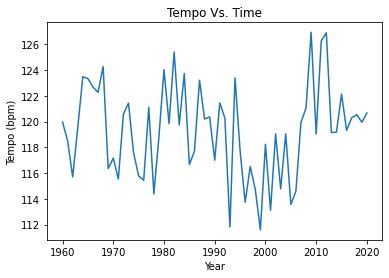

In [27]:
# Create a dataframe of the average of each feature per year
avgs = data.groupby("Year").mean().reset_index()

# Graph the relationship of tempo over time
ax = avgs.plot(x="Year", y="tempo")

# Labels
ax.set_ylabel('Tempo (bpm)')
ax.set_title('Tempo Vs. Time')
ax.get_legend().remove()

# Display
display()

The graph above shows the relationship between tempo (bpm) and time. Below we will analyze similar plots of the other features over time as it is often helpful to explore individual trends before explore their relationships. For the graph above, there does not appear to be a clear relationship between tempo and year a song was on the Billboard chart. If there is any relationship, it appears that the minimum tempo of songs on the top chart has increase fairly significantly between years prior to 2009 and those following 2009.

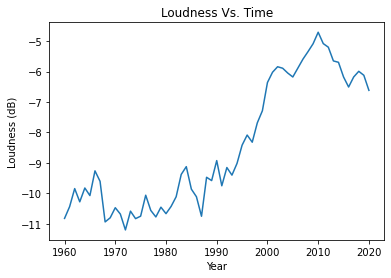

In [28]:
# Graph the relationship of loudness over time
ax = avgs.plot(x="Year", y="loudness")

# Labels
ax.set_ylabel('Loudness (dB)')
ax.set_title('Loudness Vs. Time')
ax.get_legend().remove()

# Display
display()

Here, we graphed loudness over time. This graph shows a trend where popular music increases in loudness over time. This graph peaks in 2010, but we are only plotting the mean loudness. Overall loudness has a mean of around -8 and a standard deviation of around -3, so this trend seems significant. This could be a result of differences in recording quality over time, or it could be representative of the type of music that is popular changing.

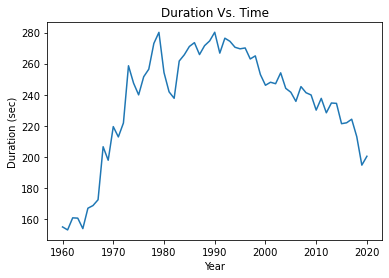

In [29]:
# Convert duration ms to seconds
avgs['duration_ms'] = avgs['duration_ms']/1000

# Graph the relationship of duration over time
ax = avgs.plot(x="Year", y="duration_ms")

# Labels
ax.set_ylabel('Duration (sec)')
ax.set_title('Duration Vs. Time')
ax.get_legend().remove()

# Display
display()

This graph shows the average duration of tracks over time. This graph has units of seconds, which is not the best for immediate comphresion of the meaning. For reference, the scale of this graph ranges from 2.67 to 4.67 minutes.

Now we will be plotting all of the features that have the same scale (0.0 to 1.0).

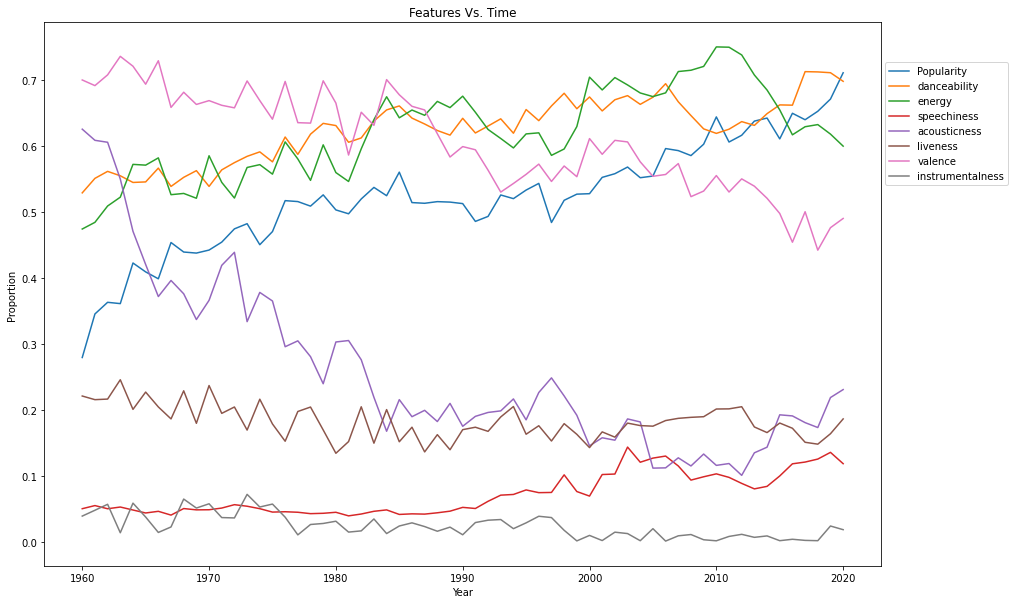

In [30]:
# Rescale average popularity to match other features
avgs['Popularity'] = avgs['Popularity'] / 100

# Array of features with 0.0 to 1.0 scale
features = ['danceability','energy','speechiness','acousticness','liveness','valence', 'instrumentalness']

# Create initial plot of popularity over time
ax = avgs.plot(x="Year", y='Popularity', figsize=(15,10))

# Add plots of other features to the plot
for feature in features:
    avgs.plot(x="Year", y=feature, ax=ax)

# Label and display
ax.set_ylabel('Proportion')
ax.set_title('Features Vs. Time')
ax.legend(loc=(1.005,0.7))
display()

This graph demonstrates some features with minimal change over time, such as instrumentalness and liveness, along with other features with stronger relationships, such as popularity. Given that popularity is a value based on Spotify listening metrics, this is expected as the songs on the Billboard Hot 100 in more recent years are likely to still be popular today, while older songs are less likely to be listened to today. Another feature with a stronger trend is acousticness. Acousticness of the Billboard Hot 100 songs has decreased over time. There are also features with visible trends that change less overall, including a slight decrease in valence, and slight increases in danceability, energy, and speechiness. The increase in danceability, energy, and speechiness together could be indicative of the rise of certain genres, possibly including hip hop/rap. Since our data only analyzes the most popular songs, these trends may or may not hold for music overall. 

After observing trends in your data, it is important to consider what this might lead you to explore next. Our observations here led us to consider trends in genres over time, as well as the relationship between audio features and different genres.

Next, we plotted the pairwise correlation coefficient between each of these features. This type of analysis helps determine how certain features are related to each other.

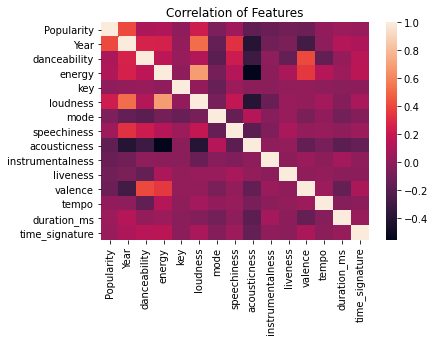

In [31]:
# Create 2D array of correlations and plot
corrs = data.drop(['Rank'], axis=1).corr()
sn.heatmap(corrs)

# Label and display
plt.title('Correlation of Features')
plt.show()

From this graph, we can see that we have very few strong correlations between different features. The strongest correlation is between loudness and energy, which is to be expected, as the Spotify documentation says that dynamic range and percieved loudness both contribute to the energy metric. Another interesting feature of this visualization is the lack of strong negative correlations. The strongest negative correlation is that between acousticness and energy, but this still has a correlation coefficient of greater than -0.6. Interestingly, acoustiness has mostly negative correlations despite these correlations being much less common overall.

Part 2.2: Exploration of Genre
===

In order to look at how the prevalence of different genres shift over time, we will plot the proportion of tracks in the Bilboard Top 100 that belong to each genre year-to-year.

In [32]:
# Create dataframe for genre percent by year
genre_percent = pd.DataFrame()

# Get percentage of year that is each genre type
for y, rows in data.groupby('Year'):
    total = len(rows)
    # Create and populate row to be added
    new_row = {}
    new_row['Year'] = y
    for g, count in rows['Top Genre'].value_counts().iteritems():
        new_row[g] = count/total
    # Add row
    genre_percent = genre_percent.append(new_row, ignore_index=True)

# Replace empty genre percentages with 0%
genre_percent = genre_percent.replace(np.nan, 0)

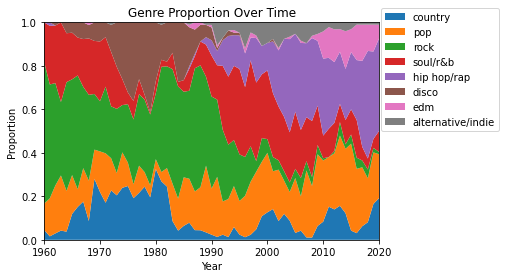

In [33]:
# Reformat genre_percent dataframe for plot
genre_columns = genre_percent.drop('Year', axis=1).transpose().to_numpy()

# Create plot showing genre division over time
plt.stackplot(genre_percent['Year'],genre_columns)

# Label and display
plt.legend(genre_percent.drop('Year', axis=1).columns,loc=(1.005,0.5))
plt.xlim(1960,2020)
plt.ylim(0,1)
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Genre Proportion Over Time')
display()

In the above plot, the 'height' of a colored region (i.e. the distance between the top and bottom) indicates the proportion of the relevant genre. From this, we can see that the proportion of genres on the Billboard Top 100 changes greatly over time. For instance, we can see that rock constitutes the largest proportion of music from 1960-1990 before quickly disappearing. Hip hop/rap, on the other hand, grows in proportion significantly from 1990 onward. EDM and alternative/indie were non-existent until recently, EDM growing in 2010 and alternative/indie in 2000. Disco constituted a large proportion in the 70s and 80s before subsequently disappearing. Pop was relatively consistent, though became larger recently. Country was prevelant in the 70s and 80s and remained in small proportions onwards. Finally, soul/r&b was a large proportion of the Top 100 in the 60s and 1990-2000, but was small in other periods.

Overall, these patterns seem consistent with the trends of music in pop culture. Considering that different genres likely have distinct audio features, these shifts in proportion may also explain changes in the proportion of audio features. Thus, we will explicity analyze the distributions of audio features in each genre.

In [34]:
# Create a dataframe of the average of each feature per genre
data.groupby('Top Genre').mean()[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
Top Genre,,,,,,,,,,,,
alternative/indie,0.542510,0.741785,4.806452,-6.095174,0.774194,0.043202,0.104419,0.022460,0.173363,0.528571,124.011626,243029.658065
country,0.576854,0.596515,5.316750,-9.108643,0.854063,0.043375,0.300146,0.012771,0.176951,0.609237,121.208128,225771.673300
disco,0.650005,0.586485,5.401408,-10.640622,0.629108,0.049814,0.293952,0.042251,0.186396,0.690267,118.331310,270524.835681
edm,0.671069,0.698082,5.364780,-5.749308,0.591195,0.100986,0.142479,0.027229,0.160148,0.526826,119.645428,220808.044025
hip hop/rap,0.734201,0.679448,5.654994,-6.289724,0.573281,0.171719,0.116275,0.013333,0.201890,0.558777,118.736595,239301.067445
pop,0.624875,0.646237,5.233302,-7.744183,0.688617,0.057938,0.261869,0.024659,0.175172,0.602963,118.965252,227133.331138
rock,0.560775,0.612283,5.083721,-9.424492,0.788372,0.045340,0.295345,0.028425,0.184704,0.607356,122.029451,231397.483721
soul/r&b,0.664520,0.573771,5.560084,-8.615846,0.594566,0.079703,0.273966,0.022854,0.172080,0.618500,114.954679,244294.026123


The table above provides a brief insight into how feature values differ across genres. In order to get a better idea of these differences, we create a violin plot for each feature by genre.

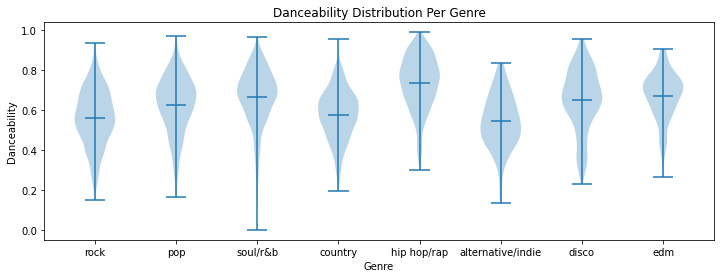

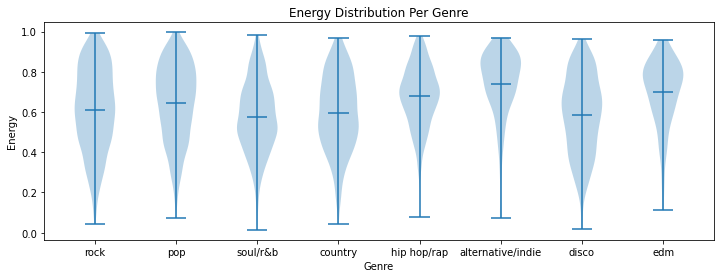

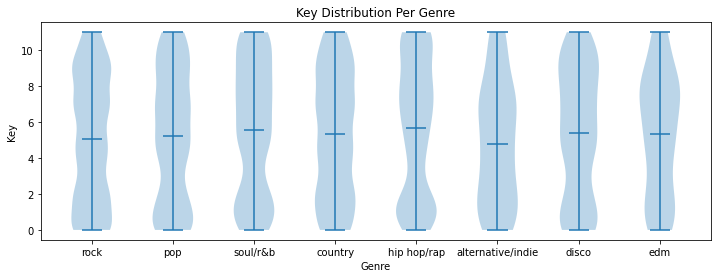

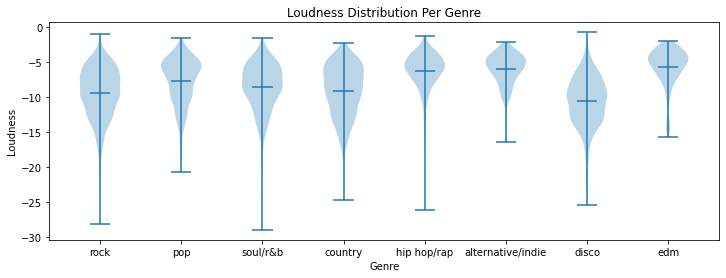

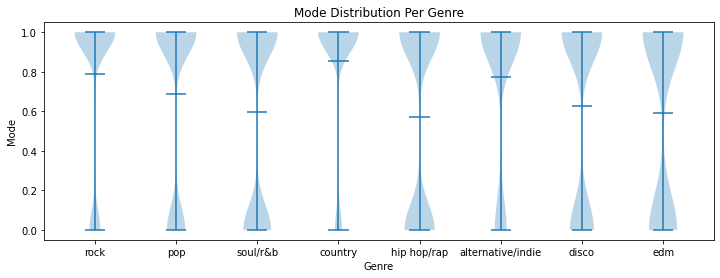

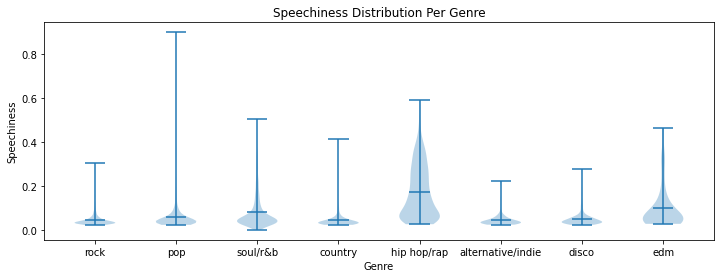

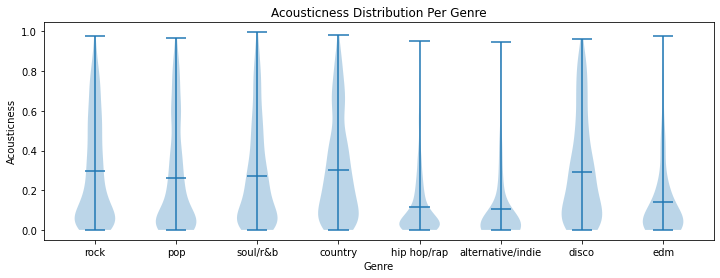

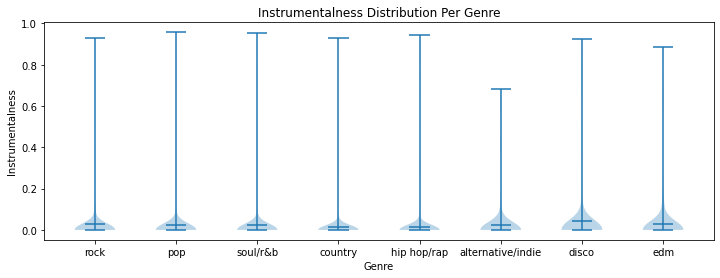

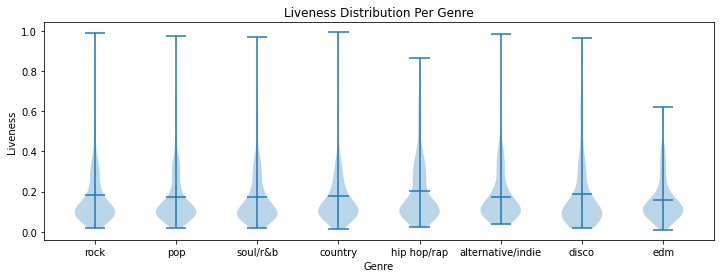

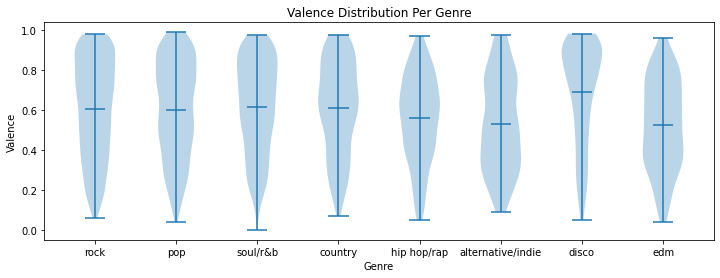

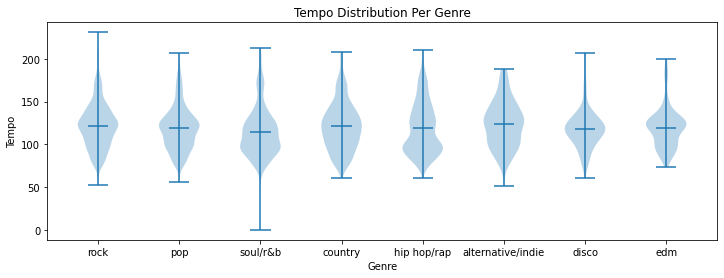

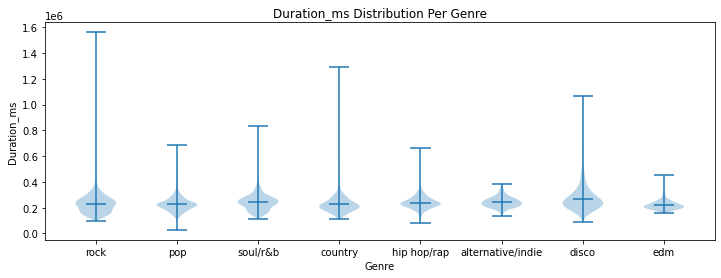

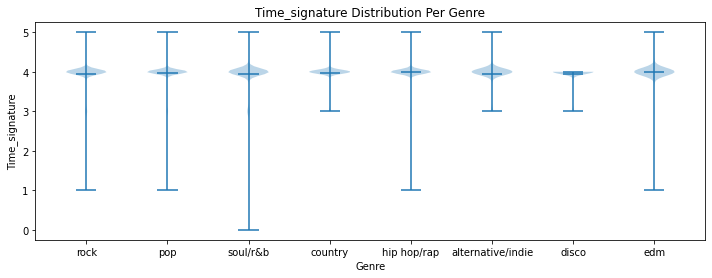

In [37]:
# Get list of genres
genres = data['Top Genre'].unique()

# Create violin plot of each feature for each genre
for feature in ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']:
    # Create array of all values of the feature for each genre
    feature_by_genre = [data.loc[data["Top Genre"] == genre][feature].values for genre in genres]

    # Create plot
    plt.figure(figsize=(12, 4))
    plt.violinplot(feature_by_genre, range(0, len(genres)), showmeans=True)

    # Label
    plt.xticks(range(0, len(genres)), labels=genres)
    plt.title(f'{feature[0].upper() + feature[1:]} Distribution Per Genre')
    plt.xlabel("Genre")
    plt.ylabel(feature[0].upper() + feature[1:])

Overall, some features vary across genre much more than others. Key, instrumentalness, liveness, duration, tempo, and time signature are mostly similar across all of the genres. Of the features that do change, here are some characteristics worth noting:

- **Dancability**: Values for Hip Hop/Rap are high and there is a wide range for Soul/R&B
- **Energy**: Alternative/Indie, Hip Hop/Rap, and EDM have high averages, and are skewed towards high values 
- **Loudness**: Pop, Alternative/Indie, and EDM have high averages, and almost all genres are skewed towards high values
- **Mode**: The mean of each genre is meaningful (and show a high proportion of country songs are major), but the data is binary, so the distribution is not very helpful
- **Speechiness**: The values for Hip Hop/Rap are significantly higher than all other genres
- **Acousticness**: Alternative/Indie, Hip Hop/Rap, and EDM have low values, all other genres are similar to each other
- **Valence**: Disco shows a higher value than all other genres

In general, violin plots are useful for most features, but are not the best visualization for others (i.e. mode), but the uniformity is useful for comparing how features are different from each other.

Part 3: Hypothesis Testing & Machine Learning
===
Now to the fun stuff! Using our newly aquired genre data, we are going to attempt to classify songs based on the audio features given by Spotify. We will do this using various classifiers provided by [scikit-learn](https://scikit-learn.org/stable/index.html). But first, we have to determine which features we are going to use.

In [50]:
# Read in the Billboard data with genres and drop empty rows
data = pd.read_csv('../data/Billboard_Audio_Features.csv')
data = data.dropna()
data.head()

,Album ID,Artist IDs,Artist(s),ID,Popularity,Query,Rank,Release Date,Song,Year,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Primary Artist ID,Genres,Top Genre
0,3bbdZdZQtCtnWEN5zG7Eyj,'3Z02hBLubJxuFJfhacLSDc',Bryan Adams,5HQ6AUDMbMuwktvcNPuV1y,36.0,track:(Everything I Do) I Do It for You artist...,1.0,1991-01-01,(Everything I Do) I Do It for You,1991.0,...,0.06480,0.000013,0.0550,0.273,131.189,398027,4,3Z02hBLubJxuFJfhacLSDc,"album rock, canadian pop, canadian singer-song...",rock
1,4zhigAhPwqp43XVHBiVeQI,'7xTcuBOIAAIGDOSvwYFPzk',Daniel Powter,0mUyMawtxj1CJ76kn9gIZK,75.0,track:Bad Day artist:Daniel Powter,1.0,2005-02-22,Bad Day,2006.0,...,0.44800,0.003360,0.1510,0.520,140.046,233640,4,7xTcuBOIAAIGDOSvwYFPzk,"canadian pop, neo mellow, pop rock",pop
2,0jZfbz0dNfDjPSg0hYJNth,'72OaDtakiy6yFqkt4TsiFt',Cher,2goLsvvODILDzeeiT4dAoR,76.0,track:Believe artist:Cher,1.0,1998-01-01,Believe,1999.0,...,0.00820,0.000000,0.0509,0.459,132.975,239027,4,72OaDtakiy6yFqkt4TsiFt,"dance pop, hollywood, new wave pop, pop, pop rock",pop
3,2Jmuuw5ff8gAGAP6B1yKKJ,'5PN2aHIvLEM98XIorsPMhE',Kim Carnes,0kPeymTUiaidv48eRrMISu,64.0,track:Bette Davis Eyes artist:Kim Carnes,1.0,2007-01-01,Bette Davis Eyes,1981.0,...,0.01740,0.000000,0.1980,0.560,116.685,224693,4,5PN2aHIvLEM98XIorsPMhE,"new wave pop, soft rock",rock
4,4yP0hdKOZPNshxUOjY0cZj,'1Xyo4u8uXC1ZmMpatF05PJ',The Weeknd,0VjIjW4GlUZAMYd2vXMi3b,94.0,track:Blinding Lights artist:The Weeknd,1.0,2020-03-20,Blinding Lights,2020.0,...,0.00146,0.000095,0.0897,0.334,171.005,200040,4,1Xyo4u8uXC1ZmMpatF05PJ,"canadian contemporary r&b, canadian pop, pop",soul/r&b


In [51]:
# Obtain the list of features we might want to use
feature_list = list(data.columns.values)
feature_list = feature_list[10:22]
feature_list

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

We need to determine which audio features vary between genres. Thankfully, [scipy](https://www.scipy.org/docs.html) allows us to run hypothesis tests to determine if any differences are statistically significant. An ANOVA test allows us to test variance between many groups, but it assumes that the data is normally distributed between samples. Since we do not want to look at all 96 histograms, we are gonna use the Kruskal-Wallis H Test which does not have the normality assumption.

In [52]:
import scipy
from scipy import stats

# The list of genres
genre_list = ['hip hop/rap','alternative/indie','country','disco','edm',
             'pop','rock','soul/r&b']

# Run Kruskal-Wallis for each feature
for feature in feature_list:
    genre_frames = []
    
    # Create a frame for each genre, and include it in the test as a parameter
    for genre in genre_list:
        genre_frames.append(data[data['Top Genre'] == genre][feature])
        
    t, p = scipy.stats.kruskal(genre_frames[0],genre_frames[1],
                              genre_frames[2],genre_frames[3],
                              genre_frames[4],genre_frames[5],
                              genre_frames[6],genre_frames[7])
    print(feature + ": t: " + str(t) + " p-value: " + str(p))
    print("")

danceability: t: 892.0653791458489 p-value: 2.481648369683846e-188

energy: t: 282.5551765302803 p-value: 3.200577495327485e-57

key: t: 22.058580524622368 p-value: 0.0024820045783447127

loudness: t: 846.8851729523643 p-value: 1.4099281667606597e-178

mode: t: 244.82240105668825 p-value: 3.502312772938618e-49

speechiness: t: 1336.3904842714205 p-value: 2.2325501776921572e-284

acousticness: t: 496.36764795999653 p-value: 4.840288930133197e-103

instrumentalness: t: 289.16510404008136 p-value: 1.244030697270327e-58

liveness: t: 34.83952318519514 p-value: 1.1988445159940325e-05

valence: t: 133.88666962789867 p-value: 9.679373519097457e-26

tempo: t: 72.6032348114743 p-value: 4.3927937644712003e-13

duration_ms: t: 171.90173191784524 p-value: 9.970796947188792e-34



As we can see from the results, every audio feature produced a p-value less than 0.0001. This means that the probability of all eight genres having the same population mean for each audio feature is very low. Thus, we can reject the null hypothesis that the genres have the same mean for every audio feature. Since we have reason to believe that the audio features differ between genres, we can use them as predictors in our classification models.

For our purposes, we will be using various supervised learning algorithms. This means that our model will be fit to a training set, and then we will test how well the trained model predicts values in the test set. As a baseline, we will be using Multi-class Linear Discriminant Analysis which finds a linear combination of features that characterizes data into classes. It is described in detail [here](https://en.wikipedia.org/wiki/Linear_discriminant_analysis). LDA has no hyperparameters--parameters used to control the machine learning process.

In [53]:
# X is the list of inputs to our model, each input is the list of audio features for each observation
# Y is the list of true outputs, each output is the genre for each observation
X = data[feature_list].values
Y = data['Top Genre'].values

E:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                   precision    recall  f1-score   support

alternative/indie       0.09      0.02      0.03        47
          country       0.00      0.00      0.00       181
            disco       0.48      0.17      0.25       128
              edm       0.00      0.00      0.00        48
      hip hop/rap       0.60      0.57      0.58       231
              pop       0.27      0.33      0.30       319
             rock       0.40      0.72      0.52       387
         soul/r&b       0.35      0.34      0.35       287

         accuracy                           0.39      1628
        macro avg       0.27      0.27      0.25      1628
     weighted avg       0.34      0.39      0.

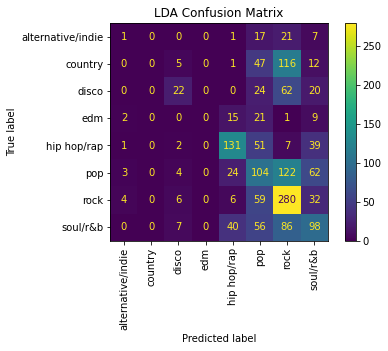

In [54]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Splits the data into training and testing sets
# We stratify the sets so the sets of a proportionate amount of each genre
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.30)

# Create LDA and fit it to the training data
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, Y_train);

# Make predictions with the trained model
Y_pred = lda_clf.predict(X_test)

# Print metrics and confusion matrix
print(metrics.classification_report(Y_test,Y_pred))

plot_confusion_matrix(lda_clf, X_test, Y_test, xticks_rotation='vertical')
plt.title('LDA Confusion Matrix')
plt.show()

In our confusion matrix, the columns refer to the predicted label and the rows refer to the true label of the observations. Each square shows the number of true/predicted label pairs. For instance, we can see that 280 observations that were predicted as rock were actually rock. We also see that that for some heavily populated squares the predicted and true genres do not match up. For instance, for observations that were actually country, 47 were predicted as pop and 116 were predicted as rock. This tells us that the features of some genres may be very similar, which makes sense for country, pop, and rock. It also tells us that we may not have placed songs in the correct genre in our original dataset. To limit the amount of genres that had few or no correct predictions, let's perform the same analysis on only rock, pop, hip hop/rap, and r&b/soul.

              precision    recall  f1-score   support

 hip hop/rap       0.71      0.63      0.67       232
         pop       0.40      0.34      0.37       319
        rock       0.56      0.71      0.62       387
    soul/r&b       0.43      0.38      0.41       287

    accuracy                           0.52      1225
   macro avg       0.53      0.52      0.52      1225
weighted avg       0.52      0.52      0.52      1225



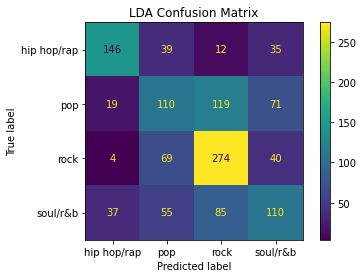

In [55]:
# Drop the genres we are no longer looking at
data = data[data['Top Genre'] != "country"]
data = data[data['Top Genre'] != "edm"]
data = data[data['Top Genre'] != "disco"]
data = data[data['Top Genre'] != "alternative/indie"]

# Obtain inputs and outputs
X = data[feature_list].values
Y = data['Top Genre'].values

# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.30)
# Create and fit LDA
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, Y_train);

# Predict on test set
Y_pred = lda_clf.predict(X_test)

# Print metrics and confusion matrix
print(metrics.classification_report(Y_test,Y_pred))

plot_confusion_matrix(lda_clf, X_test, Y_test)
plt.title('LDA Confusion Matrix')
plt.show()

Much better! Now we have a good amount of correct predictions for every genre. It still seems that a large number of pop and soul/r&b songs are being misclassified as rock. However, the majority of rock and hip hop/rap songs are correctly predicted. Looking at the classification report, we have three metrics: precision, recall, and f1 score. The precision for a genre measures the ability of the classifier to not measure an observation of another genre as that genre (i.e. more false positives = less precision). The recall for a genre measures the ability of the classifier to find all instances of that genre. F1 score is the harmonic mean of precision and recall. For all three metrics, a score of 1 is the highest. Applying these, we can see that hip hop/rap has the best precision, meaning that few things that are actually not hip hop/rap are classfied as hip hop/rap. Rock has the best recall, meaning that most instances of rock are found and labelled as such.

While LDA seems to do fairly well in categorizing songs by genre, it does not give us an idea of what distinguishes the different genres. Another model, the decision tree classifier, can make observations about a song (i.e., ask questions about its audio features) and conclude its genre. Read about the model [here](https://en.wikipedia.org/wiki/Decision_tree_learning). Luckily, scikit has a easy way to visualize the model's decision making process.

Also, an important practice in datascience is parsimony. That is, limiting the amount of features you use in predictive model. Having too many features, especially in a decision tree with a large depth, can contribute to overfitting. As such, we will be only including a subset of features that displayed the smallest p-values in our Kruskal-Wallis Test from earlier.

Another consideration of decision trees is its hyperparameters which can be tuned to produce different results. For a decision tree, some of the parameters to consider are max depth, splitter, the minimum number of samples to split a node, and the minimum number of samples allowed in a leaf node. Splitter refers to the strategy used to split a node, which can be either "best" or "random". Choosing the "best" split can be problematic for overfitting and so often choosing "random" solves this. In general, the default values of scikit work, but for our purposes we will be using a max depth of three. By default, there is no maximum depth which can contribute to both overfitting and performance issues. Moreover, any depth less than three would have trouble classifying our genres.

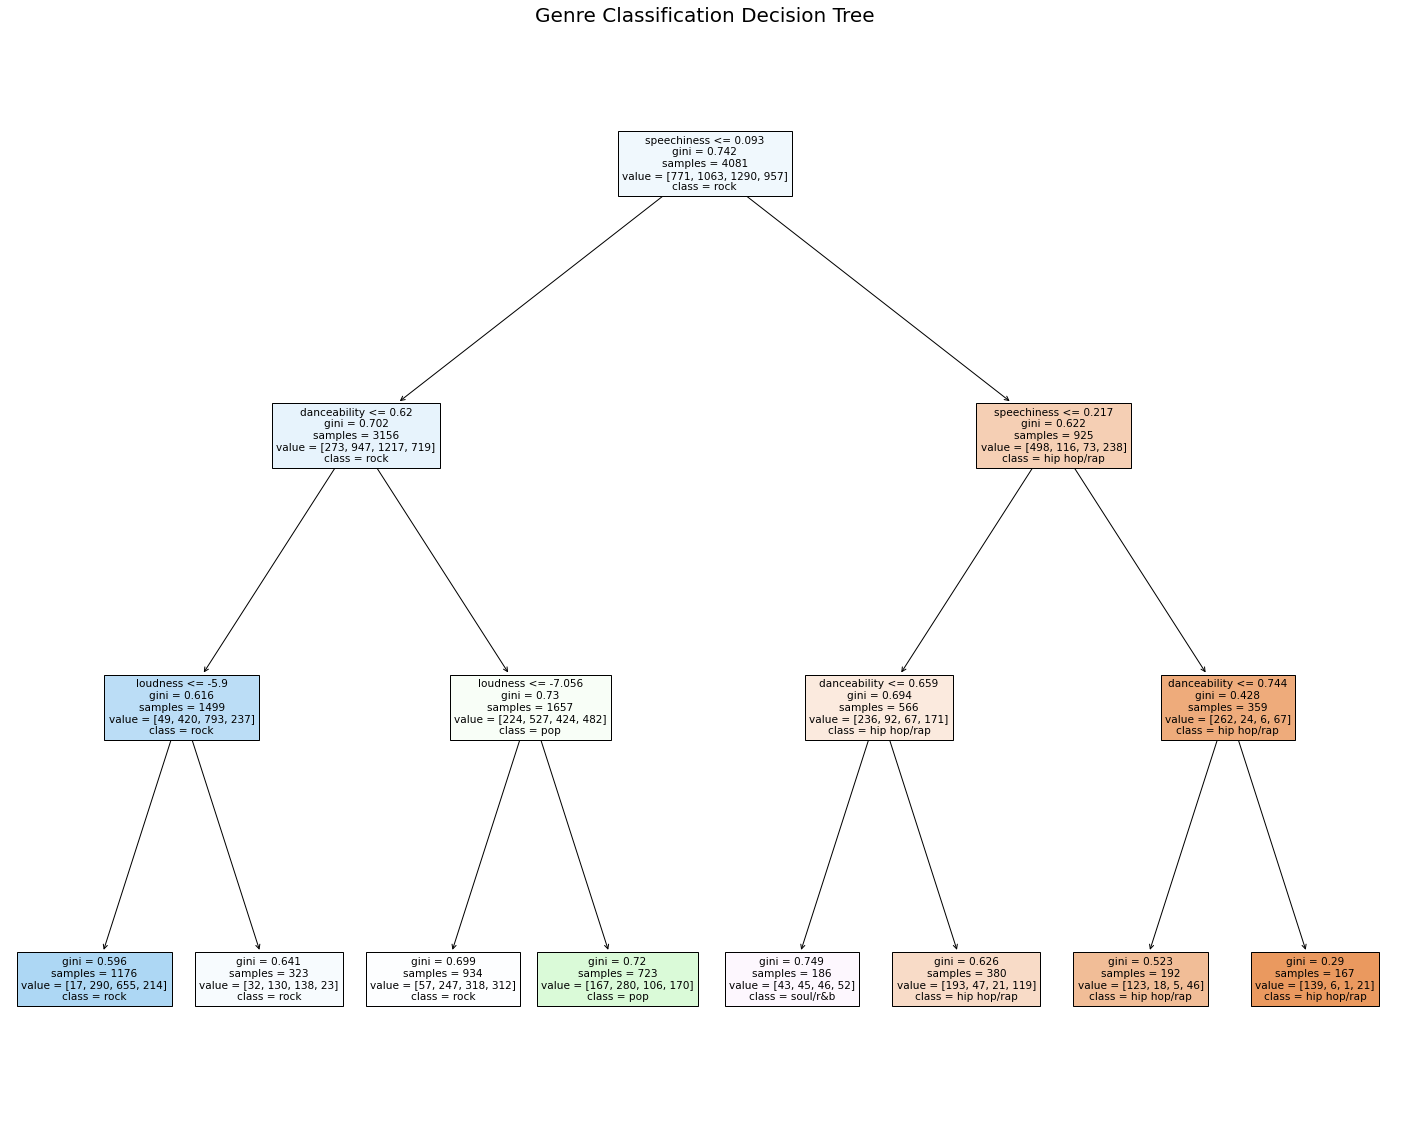

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Remove the features we are no longer using
feature_list = list(data.columns.values)
feature_list = feature_list[10:22]
feature_list.remove("liveness")
feature_list.remove("valence")
feature_list.remove("acousticness")
feature_list.remove("tempo")
feature_list.remove("key")

# List of genres we are looking at
genre_list = ['hip hop/rap',
             'pop','rock','soul/r&b']

# List of inputs and outputs
X = data[feature_list].values
Y = data['Top Genre'].values

# Create and fit a decision tree classifier
dt_clf = DecisionTreeClassifier(max_depth=3)
model = dt_clf.fit(X, Y)

# Plot the visualization of the decision tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_clf, 
                   feature_names=feature_list,
                   class_names=genre_list,
                   filled=True)
plt.title('Genre Classification Decision Tree',fontdict={'fontsize':20})
plt.show()

Each node of the resulting tree shows a decision step in the classifying process. For instance, the first node asks whether the song has a speechiness above a certain threshold. If it does, the song goes to the right branch, if not it goes to the left. Once the song reaches a leaf, it is predicted to be whatever genre that leaf represents. From this, we can make observations like the fact that hip hop/rap tends to be speechy, which makes sense given the prescence of spoken word in that genre. Let's test the classifier and see how it compares to LDA.

              precision    recall  f1-score   support

 hip hop/rap       0.64      0.56      0.60       232
         pop       0.36      0.23      0.28       319
        rock       0.50      0.61      0.55       387
    soul/r&b       0.34      0.40      0.37       287

    accuracy                           0.45      1225
   macro avg       0.46      0.45      0.45      1225
weighted avg       0.45      0.45      0.45      1225



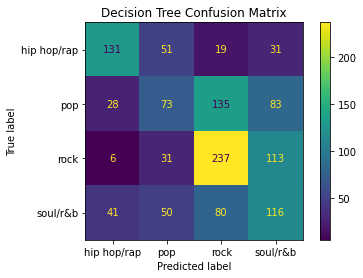

In [68]:
# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.30)

# Create and fit classifier
dt_clf = DecisionTreeClassifier(max_depth=3)
model = dt_clf.fit(X_train, Y_train)

# Predict using fitted model
Y_pred = dt_clf.predict(X_test)

# Print metrics and confusion matrix
print(metrics.classification_report(Y_test,Y_pred))

plot_confusion_matrix(dt_clf, X_test, Y_test)
plt.title('Decision Tree Confusion Matrix')
plt.show()

The result seems comparable to LDA. However, it seems that more songs were classified as soul/r&b, both correctly and incorrectly. It is important to note that a singular decision tree is extremely inconsistent in its results.

For our last classifier, we are going to try random forest. A random forest classifier essentially works by averaging the results of many decision trees. It is meant to counter the issues of overfitting and inconsistency prevelant in singular decision trees. You can read more about them [here](https://en.wikipedia.org/wiki/Random_forest).

Random forest classifiers also have a wide variety of hyper parameters to consider. For instance, you can choose the number of trees in the forest. You can also choose any of the same parameters as the decision tree classifier, which will be applied to every tree in the forest. For our purposes, we will be again using the default values in addition to a max depth of three. The default number of trees is 100, which helps us average out the results of many potentially poor decision trees.

              precision    recall  f1-score   support

 hip hop/rap       0.60      0.62      0.61       232
         pop       0.39      0.30      0.34       319
        rock       0.51      0.83      0.63       387
    soul/r&b       0.51      0.18      0.27       287

    accuracy                           0.50      1225
   macro avg       0.50      0.48      0.46      1225
weighted avg       0.50      0.50      0.47      1225



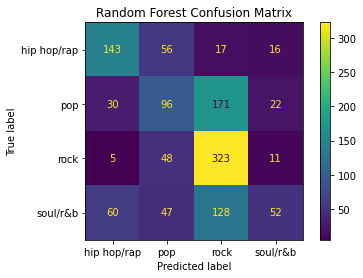

In [70]:
from sklearn.ensemble import RandomForestClassifier

# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.30)

# Create and fit random forest classifier
rfc_clf = RandomForestClassifier(max_depth=3)
model = rfc_clf.fit(X_train, Y_train)

# Predict using trained model
Y_pred = rfc_clf.predict(X_test)

# Print metrics and confusion matrix
print(metrics.classification_report(Y_test,Y_pred))

plot_confusion_matrix(rfc_clf, X_test, Y_test)
plt.title('Random Forest Confusion Matrix')
plt.show()

Again, the model appears comparable to the other two. However, in this case, it seems to classify many more cases as rock, both correctly and incorrectly. In particular, a large number of soul/r&b and pop songs are classified as rock.

Comparing models through the confusion matrices alone is insufficient. For one, we based our analysis on a single training/test split. The performance of a model can vary greatly split-to-split. Secondly, it is difficult to compare models based on the quantity of actual/predicted pairings alone. How many of each genre were in the test split and what do we care about more, correctly classifiying rock samples or soul/r&b?

These questions are answered through cross validation. K-fold cross validation works by breaking the data into K random folds, where each fold represents 1/K of the data. The data is trained on the remaining part of the data and is tested on the 1/K fold. This is done K times, until all of these 1/K-sized samples have been scored. In our case, we are scoring with the f1 macro, which is applicable in multi-class scenarios and is the mean of the per-class f1 scores. As with f1 score, a score of 1 is the highest.

Scikit provides a cross validation function for its models. We will be using 10 folds, so we will test each model on 10 folds, returning the f1 macro for each fold.

In [71]:
from sklearn.model_selection import cross_val_score

# Create LDA and run 10-fold cross validation
lda_clf = LinearDiscriminantAnalysis()
lda_scores = cross_val_score(lda_clf, X, Y, cv=10, scoring='f1_macro')

# Create random forest and run 10-fold cross validation
rfc_clf = RandomForestClassifier(max_depth=3)
rfc_scores = cross_val_score(rfc_clf, X, Y, cv=10, scoring='f1_macro')

# Create decision tree and run 10-fold cross validation
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_scores = cross_val_score(dt_clf, X, Y, cv=10, scoring='f1_macro')

In [72]:
# Print average scores and standard error
print(f"Average LDA f1 score:{lda_scores.mean()}\tStandard Error:{lda_scores.std()}\n")
print(f"Average RFC f1 score:{rfc_scores.mean()} \tStandard Error:{rfc_scores.std()}\n")
print(f"Average DT f1 score:{dt_scores.mean()}  \tStandard Error:{dt_scores.std()}\n")

Average LDA f1 score:0.48604832593261077	Standard Error:0.03529134309428848

Average RFC f1 score:0.4481556873587225 	Standard Error:0.017199063324212588

Average DT f1 score:0.3885433942651619  	Standard Error:0.04012772693405444



In [73]:
# Run Kruskal-Wallis on the three score lists
t, p = scipy.stats.kruskal(lda_scores,rfc_scores,dt_scores)
print(f"t: {t}\tp-value: {p}")

t: 17.77806451612902	p-value: 0.00013789303830809166


Judging by our cross validation procedure, LDA performed the best with the highest mean macro f1 score. Random forest performed the next best and decision tree performed the worst. Our Kruskal-Wallis Test produced a very small p-value, meaning we can reject the null hypothesis at the 0.05 level of significance that the models have the same mean f1 score. This means that it is very likely that the models perform differently.

In our case, it seems that LDA and the random forest performed fairly similarly, but the decision tree performed significantly worse. This showcases the fact that a singular decision tree tends to have inconsistent results as compared to a random forest. In general, it seems that classification by genre is relatively difficult with the data we have. Specifically, many pop, rock, and soul/r&b tracks seem to have similar audio features. It should be noted that these results are not final, however. One could attempt to tune the hyperparameters or could even try another model. Not all models are equally applicable to the same dataset, so maybe something other than LDA and random forests would be more appropriate. 

Part 4: Conclusion
===

Congrats, you have made it to the end! At the start of this tutorial, we wanted to look at how audio features provided by the Spotify API showcase the differences between tracks over time and between genres. To do so, we learned how to scrape Wikipedia, call the Spotify API, and rearrange the data into a usable form. We also learned how to perform exploratory analysis and to leverage machine learning to classify data based on a set of features. But, we have yet to teach you the most important step of data analysis: repeating all the other steps! In fact, there were many points at which we could have went in several directions.

In our case, we produced several models that could classify between 4 types of music using a subset of audio features to varying degrees of efficacy. We found that, given the data we had, classification is difficult. While many genres had features that made them distiguishable from others, such as the high speechiness of hip hop/rap, other genres, like country, were largely indistinguishable. This could either be due to the inherent similarities between genres, or a flaw in our process of placing tracks into categories. Regardless, the data and methods we chose had a profound effect on the results we had.

Perhaps our data, featuring all Bilboard Top 100s since the 1960s, was better suited towards time series analysis. We may have produced better results with data geared towards classfication, such as taking songs from a variety of curated playlists by genre. Perhaps it was our method of categorizing the data, maybe country should fall in the rock category due to similarities, or maybe we should consider all artists on a track rather than just the primary one. Perhaps genres are inherently indistinguishable by Spotify's audio features. These are all questions that can be answered through further analysis. Are you up for the challenge?